# MNIST Model for Digit Classification

In [1]:
import numpy as np
import sklearn
import os,os.path 
import gzip
import sys
import time
import random 

import urllib 
import matplotlib
import matplotlib.pyplot as plt

In [2]:
# Dimensions of images in pixels.
IMAGEW = 28
IMAGEH = 28

LABELS = 10

In [3]:
def cached_download(filename):
    """
    Only download data files if necessary.
    """
    try:
        os.stat('./DATA')
    except:
        os.mkdir('./DATA')
    
    filepath = os.path.join('./DATA', filename)
    
    if not os.path.isfile(filepath):
        filepath, headers = urllib.request.urlretrieve(URLBASE + filename, filepath)
    
    return filepath

In [4]:
def unpack_files(imagefile, labelsfile, count):
    with gzip.open(imagefile) as f:
        f.read(16)
        buf = f.read(IMAGEW * IMAGEH * count)
        images = np.frombuffer(buf, dtype = np.uint8).astype(np.float32)
        images = images.reshape(count, IMAGEW, IMAGEH)

    with gzip.open(labelsfile) as f:
        f.read(8)
        labels = np.frombuffer(f.read(1 * count), dtype = np.uint8).astype(np.int64)
    
    return (images, labels)

In [5]:
URLBASE = 'http://yann.lecun.com/exdb/mnist/'

images_pathname = cached_download('train-images-idx3-ubyte.gz')
labels_pathname = cached_download('train-labels-idx1-ubyte.gz')

images, labels = unpack_files(images_pathname, labels_pathname, 60000)

# Visualize Data

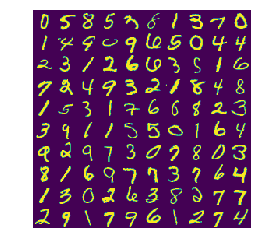

In [7]:
imgmatrix = np.vstack([np.hstack([images[random.randrange(len(labels)),:,:] for i in range(10)]) for j in range(10)])

plt.imshow(imgmatrix, interpolation = 'nearest')
plt.axis('off')
plt.show()

# Define functions for training and predicting

In [8]:
def soft_max(scores):
    """
    Convert scores to probabilities.
    """
    exp_scores = np.exp(scores)
    return exp_scores / np.sum(exp_scores, axis = 1, keepdims = True)

def predict(model, x): 
    """
    Generate a prediction via forward propagation. Predicts on minibatch.
    """
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    
    # Input values to hidden layer.
    z1 = x.dot(W1) + b1
    # Activation of hidden layer.
    a1 = np.tanh(z1)
    # Input to ouput layer.
    z2 = a1.dot(W2) + b2
    
    return soft_max(z2)

def predict_class(model, x):
    return np.argmax(predict(model, x), axis = 1)

In [9]:
def loss(model, x, y):
    """
    Evaluate cross-entropy loss.
    """
    W1, W2 = model['W1'], model['W2']
    
    probs = predict(model, x)
    N = len(y)
    
    L = np.sum(-np.log(probs[range(N), y]))
    
    # Add regularization.
    L += LAMBDA / 2 * (np.sum(np.square(W1)) + np.sum(np.square(W2)))
    
    return L / N

In [10]:
def build_model(hdim, nbatch, passes = 20000, verbose = False, model = None):
    """
    Train model using backward propagation and batch gradient descent.
    
    :param hdim: Number of hidden nodes.
    :param passes: Number of iterations.
    :param verbose: Whether or not to produce status information.
    :return: data frame.
    """
    if model:
        W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    else:
        np.random.seed(0)
        W1 = np.random.randn(idim, hdim) / np.sqrt(idim)
        b1 = np.zeros((1, hdim))
        W2 = np.random.randn(hdim, odim) / np.sqrt(hdim)
        b2 = np.zeros((1, odim))

    
    for i in range(0, passes):
        index=random.sample(range(len(labels)), nbatch)
        X= images[index,]
        y = labels[index]
    
        # Generate predictions with current model via forward propagation.
        z1 = X.dot(W1) + b1 
        a1 = np.tanh(z1) 

        z2 = a1.dot(W2) + b2

        delta = soft_max(z2)

        delta[range(nbatch), y] -= 1
        # (idim, N) x (N, odim) -> (idim, odim)
        dW2 = (a1.T).dot(delta)  
        db2 = np.sum(delta, axis = 0, keepdims = True)
        delta2 = delta.dot(W2.T) * (1 - np.power(a1, 2)) 
        dW1 = np.dot(X.T, delta2)
        db1 = np.sum(delta2, axis=0)

        # Update model parameters, including regularisation.
        W1 += -epsilon * (dW1 + LAMBDA * W1)
        b1 += -epsilon * db1
        W2 += -epsilon * (dW2 + LAMBDA * W2)
        b2 += -epsilon * db2
        
        model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}
        
        if verbose and i % 1000 == 0:
          print("iteration %i: Loss = %f" %(i, loss(model, X, y)))
    
    return model

# Build model

Set up model parameters.

In [11]:
idim = IMAGEW * IMAGEH
odim = LABELS

hdim = 25

# Size of mini-batch.
NBATCH = 220

Flatten image data

In [15]:
images = images.reshape(len(labels), -1)
images.shape

(60000, 784)

Define learning rate (epsilon) and Regularization rate (LAMBDA)

In [16]:
epsilon = 0.00001

LAMBDA = 0.02

Build model using mini-batch of dataset.

In [17]:
model = build_model(hdim, NBATCH, verbose = True)

iteration 0: Loss = 2.536998
iteration 1000: Loss = 0.757345
iteration 2000: Loss = 0.616974
iteration 3000: Loss = 0.429872
iteration 4000: Loss = 0.387917
iteration 5000: Loss = 0.386503
iteration 6000: Loss = 0.398760
iteration 7000: Loss = 0.290444
iteration 8000: Loss = 0.419116
iteration 9000: Loss = 0.235276
iteration 10000: Loss = 0.322860
iteration 11000: Loss = 0.312089
iteration 12000: Loss = 0.275188
iteration 13000: Loss = 0.243744
iteration 14000: Loss = 0.335684
iteration 15000: Loss = 0.348816
iteration 16000: Loss = 0.358841
iteration 17000: Loss = 0.263860
iteration 18000: Loss = 0.207795
iteration 19000: Loss = 0.199818


More iterations on the same model using same learning rate and regularization.

In [18]:
epsilon = 0.00001
LAMBDA = 0.02

model = build_model(hdim, NBATCH, verbose = True, model = model)

iteration 0: Loss = 0.207511
iteration 1000: Loss = 0.274983
iteration 2000: Loss = 0.233689
iteration 3000: Loss = 0.237669
iteration 4000: Loss = 0.184463
iteration 5000: Loss = 0.218295
iteration 6000: Loss = 0.266675
iteration 7000: Loss = 0.274928
iteration 8000: Loss = 0.289215
iteration 9000: Loss = 0.268155
iteration 10000: Loss = 0.200461
iteration 11000: Loss = 0.181579
iteration 12000: Loss = 0.222092
iteration 13000: Loss = 0.265030
iteration 14000: Loss = 0.257998
iteration 15000: Loss = 0.243459
iteration 16000: Loss = 0.176114
iteration 17000: Loss = 0.225789
iteration 18000: Loss = 0.191942
iteration 19000: Loss = 0.149643


# Make predictions on training set

In [19]:
labels_predict = predict_class(model, images)

Compare first 10 predictions against actual labels.

In [20]:
labels[0:10]

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4])

In [21]:
labels_predict[0:10]

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4])

# Get testing data

In [22]:
test_images_pathname = cached_download('t10k-images-idx3-ubyte.gz')
test_labels_pathname = cached_download('t10k-labels-idx1-ubyte.gz')

In [23]:
test_images, test_labels = unpack_files(test_images_pathname, test_labels_pathname, 10000)

Flatten testing data.

In [24]:
test_images = test_images.reshape(len(test_labels), -1)

Generate predictions for testing data. 

In [25]:
test_labels_predict = predict_class(model, test_images)

Calculate accuracy

In [26]:
sum(test_labels_predict == test_labels) / len(test_labels)

0.92820000000000003